In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [23]:


# Read CSV data
df = pd.read_csv(r'GPM_DataProject\Urban-Rainfall-Analysis-and-Prediction-GPM-Data-project-\data_preprocessing\finalprecipitation_data.csv')

# Convert 'Date' to datetime format and extract year, month, and day
df['Date'] = pd.to_datetime(df['Date'])

# Select numerical features for prediction
numerical_columns = ['Specific_Humidity_10m', 'Air_Temperature_2m', 'Eastward_Wind_10m', 'Northward_Wind_10m']
df[numerical_columns] = df[numerical_columns].astype(float)

# Encode categorical 'Zone_Name'
label_encoder = LabelEncoder()
df['Zone_Code'] = label_encoder.fit_transform(df['Zone_Name'])

# Define features (X) and target variable (y)
X = df[['Zone_Code'] + numerical_columns]
y = df['Precipitation_mm']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale numerical features with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Create sequences for LSTM
def create_sequences(dataX, dataY, timesteps):
    X_new, y_new = [], []
    for i in range(len(dataX) - timesteps + 1):
        X_new.append(dataX[i:(i + timesteps), :])
        y_new.append(dataY.iloc[i + timesteps - 1])
    return np.array(X_new), np.array(y_new).reshape(-1, 1)  # Reshape y_new to match the shape of X_new

# Set timesteps (look back window)
timesteps = 7  #  Look back at 7 days of data
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test, timesteps)

# Build LSTM model with dropout and early stopping
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))  # Add dropout after first LSTM layer
model.add(LSTM(50))
model.add(Dropout(0.2))  # Add dropout after second LSTM layer
model.add(Dense(1, activation='relu'))  # One output neuron for precipitation prediction with ReLU activation
model.compile(loss='mse', optimizer='adam')  # Use Adam optimizer

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model with validation data for early stopping
model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

# Predictions
y_pred_train = model.predict(X_train_seq)
y_pred_test = model.predict(X_test_seq)

# Evaluate the model (using scaled values here)
print("Training RMSE:", mean_squared_error(y_train_seq, y_pred_train, squared=False))
print("Testing RMSE:", mean_squared_error(y_test_seq, y_pred_test, squared=False))


Epoch 1/10
274/274 [==============================] - 5s 8ms/step - loss: 4.4990 - val_loss: 10.3759
Epoch 2/10
274/274 [==============================] - 2s 6ms/step - loss: 4.3186 - val_loss: 10.3226
Epoch 3/10
274/274 [==============================] - 2s 7ms/step - loss: 4.2563 - val_loss: 9.8242
Epoch 4/10
274/274 [==============================] - 1s 5ms/step - loss: 4.2033 - val_loss: 9.4823
Epoch 5/10
274/274 [==============================] - 2s 6ms/step - loss: 4.1424 - val_loss: 9.6903
Epoch 6/10
274/274 [==============================] - 2s 6ms/step - loss: 4.1464 - val_loss: 10.2717
Epoch 7/10
274/274 [==============================] - 2s 6ms/step - loss: 4.1355 - val_loss: 9.5995
Epoch 8/10
274/274 [==============================] - 2s 6ms/step - loss: 4.1172 - val_loss: 9.3292
Epoch 9/10
274/274 [==============================] - 2s 6ms/step - loss: 4.1032 - val_loss: 10.1185
Epoch 10/10
69/69 [==============================] - 0s 2ms/step
Training RMSE: 2.00825411153437

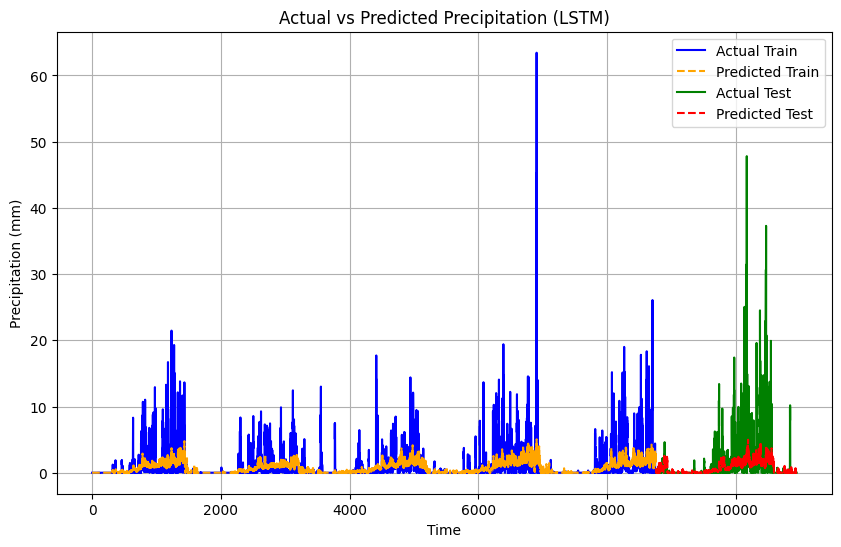

In [24]:


# Plot the performance
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(y_train_seq, label='Actual Train', color='blue')
plt.plot(y_pred_train, label='Predicted Train', linestyle='--', color='orange')

# Plot testing data
plt.plot(np.arange(len(y_train_seq), len(y_train_seq) + len(y_test_seq)), y_test_seq, label='Actual Test', color='green')
plt.plot(np.arange(len(y_train_seq), len(y_train_seq) + len(y_test_seq)), y_pred_test, label='Predicted Test', linestyle='--', color='red')

plt.title('Actual vs Predicted Precipitation (LSTM)')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()